## Load Data + Feature Engineering

#### Junrui/Daisy Code from GitHub:

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# Set path to local data directory
folder_path = "/Users/ellajones/Downloads/Optiver_additional data"

# Define file paths
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load parquet files (first 30 mins = feature, last 30 mins = target side of the hour)
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')

# Concatenating both DataFrames vertically (stacking feature + target rows)
# Note: This doesn't align features and targets — it's just combining both halves of the hour
combined_df = pd.concat([feature_df, target_df], axis=0)

# Sort to organize by stock, time, and within-hour time buckets
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)


In [4]:
# Apply feature engineering function to the combined DataFrame (includes both first + last 30 min)
def compute_orderbook_features(df):
    """
    Compute engineered order book features from raw order book snapshots.
    """
    df = df.copy()

    # Mid price and Weighted Average Price
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['wap'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (
        df['bid_size1'] + df['ask_size1']
    )

    # Spread and relative spread
    df['bid_ask_spread'] = df['ask_price1'] - df['bid_price1']
    df['spread_pct'] = df['bid_ask_spread'] / df['mid_price']

    # Spread variation over time within the same time_id
    df['spread_variation'] = df.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )

    # Order book imbalance and depth ratio
    df['imbalance'] = (df['bid_size1'] - df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['depth_ratio'] = df['bid_size1'] / df['ask_size1'].replace(0, np.nan)

    # Return only the engineered features
    keep_cols = [
        'stock_id', 'time_id', 'seconds_in_bucket',
        'wap', 'spread_pct', 'imbalance', 'depth_ratio', 'spread_variation'
    ]
    return df[keep_cols]

In [5]:
feature_engineered_df = compute_orderbook_features(combined_df)


In [10]:
feature_engineered_df.tail()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation
35557446,104919,1199,3595.0,362.731439,0.000028,-0.712230,0.168067,0.000012
35557447,104919,1199,3596.0,362.696000,0.000055,0.600000,4.000000,0.000012
35557448,104919,1199,3597.0,362.691818,0.000028,-0.636364,0.222222,0.000012
35557449,104919,1199,3598.0,362.721667,0.000028,-0.666667,0.200000,0.000012
35557450,104919,1199,3599.0,362.804000,0.000028,-0.200000,0.666667,0.000012


In [45]:
import random
import numpy as np

random.seed(3888)
np.random.seed(3888)

In [7]:
time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)

In [11]:
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])

In [13]:
feature_engineered_df = pd.merge(
    feature_engineered_df.drop(columns=["datetime"], errors="ignore"),  # just in case it already exists
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)

In [15]:
feature_engineered_df.tail()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,datetime
35557446,104919,1199,3595.0,362.731439,0.000028,-0.712230,0.168067,0.000012,2021-10-07 16:00:00
35557447,104919,1199,3596.0,362.696000,0.000055,0.600000,4.000000,0.000012,2021-10-07 16:00:00
35557448,104919,1199,3597.0,362.691818,0.000028,-0.636364,0.222222,0.000012,2021-10-07 16:00:00
35557449,104919,1199,3598.0,362.721667,0.000028,-0.666667,0.200000,0.000012,2021-10-07 16:00:00
35557450,104919,1199,3599.0,362.804000,0.000028,-0.200000,0.666667,0.000012,2021-10-07 16:00:00


## Baseline Model

### Train/Test : 80/20 Split

In [16]:
# Sort just in case
feature_engineered_df = feature_engineered_df.sort_values(by="time_id")

# Unique time_ids
unique_ids = sorted(feature_engineered_df["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)

# Train on earliest 80%, test on latest 20%
train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train_df_timeid = feature_engineered_df[feature_engineered_df["time_id"].isin(train_ids)]
test_df_timeid = feature_engineered_df[feature_engineered_df["time_id"].isin(test_ids)]

print("TimeID Split:")
print("Train shape:", train_df_timeid.shape)
print("Test shape:", test_df_timeid.shape)



TimeID Split:
Train shape: (28513833, 9)
Test shape: (7043618, 9)


In [17]:
qqq_df = feature_engineered_df[feature_engineered_df["stock_id"] == 104919].copy()

In [19]:
qqq_df.head()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,datetime
31393488,104919,6,2992.0,312.299875,0.000032,0.975000,79.000000,0.000017,NaT
31393489,104919,6,2993.0,312.262896,0.000064,-0.710446,0.169286,0.000017,NaT
31393490,104919,6,2993.0,312.262896,0.000064,-0.710446,0.169286,0.000017,NaT
31393491,104919,6,2994.0,312.280598,0.000064,-0.940178,0.030833,0.000017,NaT
31393492,104919,6,2994.0,312.280598,0.000064,-0.940178,0.030833,0.000017,NaT


In [21]:
qqq_df["log_return"] = qqq_df.groupby("time_id")["wap"].transform(lambda x: np.log(x / x.shift(1)))


# Compute realized volatility per time_id
rv_df = qqq_df.groupby("time_id")["log_return"].agg(lambda x: np.sqrt(np.sum(x**2))).reset_index()

rv_df = rv_df.rename(columns={"log_return": "realized_volatility"})

#  Merge back into spy_df
qqq_df = pd.merge(qqq_df, rv_df, on="time_id", how="left")


In [22]:
qqq_df.tail()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,datetime,log_return,realized_volatility
4166343,104919,1199,1969.0,364.045714,0.000055,-0.428571,0.400000,0.000014,2021-10-07 16:00:00,-0.000059,0.010677
4166344,104919,1199,1970.0,364.046133,0.000055,-0.386658,0.442317,0.000014,2021-10-07 16:00:00,0.000001,0.010677
4166345,104919,1199,1972.0,364.010909,0.000027,-0.818182,0.100000,0.000014,2021-10-07 16:00:00,-0.000097,0.010677
4166346,104919,1199,3598.0,362.721667,0.000028,-0.666667,0.200000,0.000012,2021-10-07 16:00:00,-0.003548,0.010677
4166347,104919,1199,3599.0,362.804000,0.000028,-0.200000,0.666667,0.000012,2021-10-07 16:00:00,0.000227,0.010677


for baseline, only considering the mean values for the features. Additionally no lagged features will be included in the baseline

In [51]:
xgb_df = qqq_df.groupby('time_id').agg({        
    'wap': 'mean',
    'spread_pct': 'mean',
    'imbalance': 'mean',
    'depth_ratio': 'mean',
    'spread_variation': 'mean',
    'realized_volatility': 'mean'       
}).reset_index()

In [53]:
cutoff = int(len(xgb_df) * 0.8)
train_df = xgb_df.iloc[:cutoff]
test_df = xgb_df.iloc[cutoff:]

feature_columns = ['wap', 'spread_pct', 'imbalance', 'depth_ratio', 'spread_variation']

X_train = train_df[feature_columns]
y_train = train_df['realized_volatility']
X_test = test_df[feature_columns]
y_test = test_df["realized_volatility"]


In [28]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [54]:
xgb_model1 = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=3888 #set seed
)

xgb_model1.fit(X_train, y_train)


y_pred = xgb_model1.predict(X_test)


qlike = np.mean(np.log(y_pred**2) + (y_test**2) / (y_pred**2))
mse = mean_squared_error(y_test, y_pred)


print(f"Baseline XGBoost Model Performance:")
print(f"  MSE  = {mse:.6f}")
print(f"  QLIKE = {qlike:.6f}")

Baseline XGBoost Model Performance:
  MSE  = 0.000019
  QLIKE = -8.085424


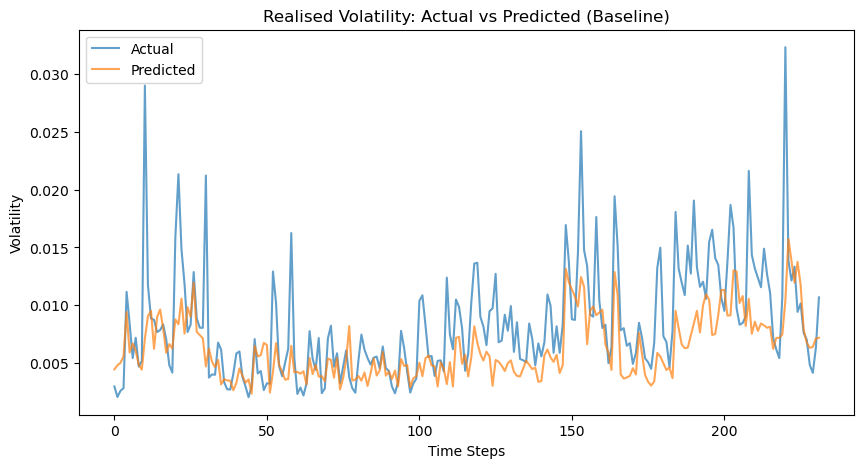

In [55]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.title("Realised Volatility: Actual vs Predicted (Baseline)")
plt.xlabel("Time Steps")
plt.ylabel("Volatility")
plt.show()

In [56]:
from xgboost import plot_importance

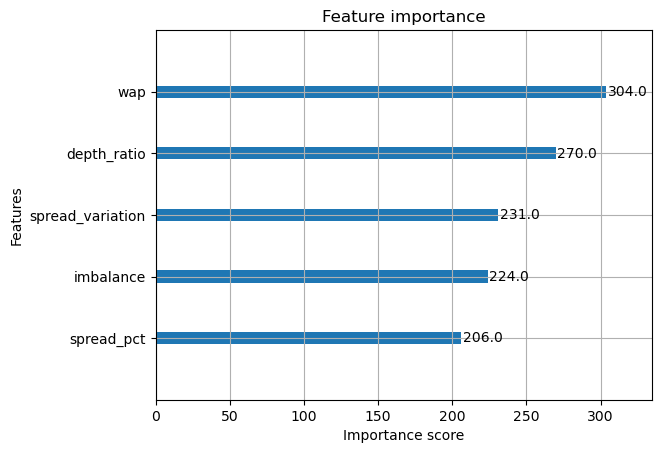

In [57]:
plot_importance(xgb_model1)
plt.show()

## Model 2: Rolling Windows + Additional Features

### Additional Features: 

In [58]:
xgb_df = xgb_df.sort_values(by="time_id")  # Important for rolling logic

# Lagged realized volatility
xgb_df["rv_lag_1"] = xgb_df["realized_volatility"].shift(1)
xgb_df["rv_lag_5"] = xgb_df["realized_volatility"].shift(5)
xgb_df["rv_lag_10"] = xgb_df["realized_volatility"].shift(10)

# Lagged predictors (example subset — add more if you like)
for col in ['wap', 'spread_pct', 'imbalance', 'depth_ratio', 'spread_variation']:
    xgb_df[f'lag_1_{col}'] = xgb_df[col].shift(1)

# Rolling stds
for col in ['wap', 'spread_pct', 'imbalance', 'depth_ratio']:
    xgb_df[f'rolling_std_5_{col}'] = xgb_df[col].rolling(window=5).std()

# Drop NaNs
xgb_df = xgb_df.dropna().reset_index(drop=True)

In [59]:
xgb_df.head()

,time_id,wap,spread_pct,imbalance,depth_ratio,spread_variation,realized_volatility,rv_lag_1,rv_lag_5,rv_lag_10,lag_1_wap,lag_1_spread_pct,lag_1_imbalance,lag_1_depth_ratio,lag_1_spread_variation,rolling_std_5_wap,rolling_std_5_spread_pct,rolling_std_5_imbalance,rolling_std_5_depth_ratio
0,16,311.632819,0.000052,-0.048561,7.588825,0.000016,0.010132,0.004842,0.011345,0.019060,310.464182,0.000055,0.061077,12.729161,0.000017,0.645210,0.000005,0.057512,2.158547
1,17,311.420499,0.000047,0.041566,8.297306,0.000015,0.007083,0.010132,0.013922,0.012017,311.632819,0.000052,-0.048561,7.588825,0.000016,0.751443,0.000006,0.057077,2.334881
2,18,309.633190,0.000057,-0.068175,3.857063,0.000017,0.018865,0.007083,0.009318,0.012870,311.420499,0.000047,0.041566,8.297306,0.000015,0.877792,0.000005,0.055711,3.409177
3,19,310.931787,0.000053,-0.055362,5.750309,0.000017,0.011327,0.018865,0.007836,0.006585,309.633190,0.000057,-0.068175,3.857063,0.000017,0.801379,0.000004,0.060341,3.324743
4,20,311.273040,0.000054,-0.004575,4.792330,0.000016,0.008167,0.011327,0.004842,0.010621,310.931787,0.000053,-0.055362,5.750309,0.000017,0.794086,0.000003,0.045191,1.864043


In [70]:

W, H, S = 330, 10, 5
all_preds = []
all_actuals = []

import random
random.seed(3888)
np.random.seed(3888)


feature_cols = [col for col in xgb_df.columns if col.startswith('lag_') or col.startswith('rolling_std')]

for start in range(0, len(xgb_df) - W - H + 1, S):
    train_window = xgb_df.iloc[start:start + W]
    test_window = xgb_df.iloc[start + W:start + W + H]

    X_train = train_window[feature_cols]
    y_train = train_window["realized_volatility"]

    X_test = test_window[feature_cols]
    y_test = test_window["realized_volatility"]

    # Train model
    xgb_model2 = XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=3888
    )
    xgb_model2.fit(X_train, y_train)

    preds = xgb_model2.predict(X_test)

    all_preds.extend(preds)
    all_actuals.extend(y_test.values)

In [71]:
pred = np.array(all_preds)
actual = np.array(all_actuals)

mse = mean_squared_error(actual, pred)
qlike = np.mean(np.log(pred**2) + (actual**2) / (pred**2))


print(f"XGBoost Model 2 Performance:")
print(f"  MSE  = {mse:.6f}")
print(f"  QLIKE = {qlike:.6f}")


XGBoost Model 2 Performance:
  MSE  = 0.000019
  QLIKE = -8.261772


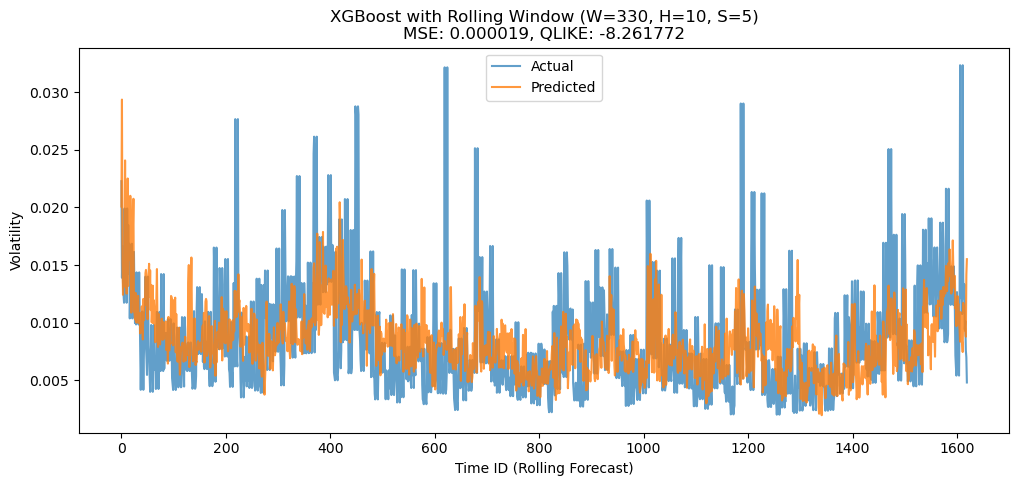

In [82]:

plt.figure(figsize=(12, 5))
plt.plot(actual, label="Actual", alpha=0.7)
plt.plot(pred, label="Predicted", alpha=0.8)
plt.title(f"XGBoost with Rolling Window (W={W}, H={H}, S={S})\nMSE: {mse:.6f}, QLIKE: {qlike:.6f}")
plt.xlabel("Time ID (Rolling Forecast)")
plt.ylabel("Volatility")
plt.legend()
plt.show()

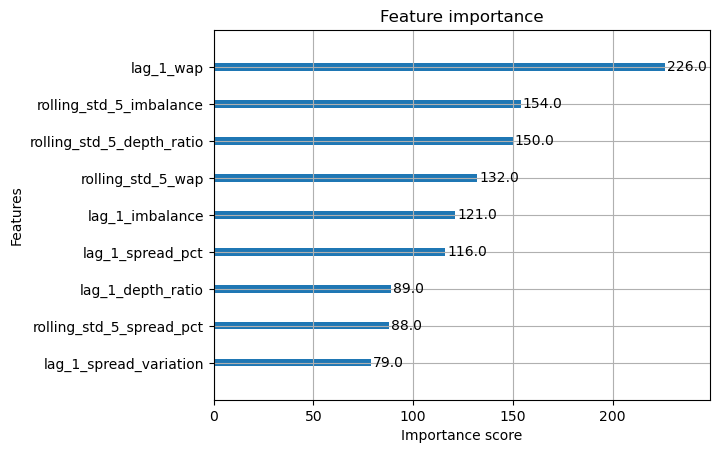

In [78]:
plot_importance(xgb_model2)
plt.show()

## Hypertuning

In [86]:
def qlike_loss(y_true, y_pred):
    epsilon = 1e-8  # prevent divide-by-zero
    return np.mean(np.log((y_pred + epsilon) ** 2) + (y_true ** 2) / ((y_pred + epsilon) ** 2))

In [ ]:
from itertools import product
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [88]:
from itertools import product
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Define parameter grid
param_grid_stage1 = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}
param_combinations = list(product(
    param_grid_stage1['max_depth'],
    param_grid_stage1['learning_rate'],
    param_grid_stage1['n_estimators']
))


W, H, S = 330, 10, 5
feature_cols = [col for col in xgb_df.columns if col.startswith('lag_') or col.startswith('rolling_std')]


random.seed(3888)
np.random.seed(3888)

best_score = float('inf')
best_params = None


for max_depth, lr, n_estimators in param_combinations:
    all_preds = []
    all_actuals = []

    for start in range(0, len(xgb_df) - W - H + 1, S):
        train_window = xgb_df.iloc[start:start + W]
        test_window = xgb_df.iloc[start + W:start + W + H]

        X_train = train_window[feature_cols]
        y_train = train_window["realized_volatility"]
        X_test = test_window[feature_cols]
        y_test = test_window["realized_volatility"]

        model = XGBRegressor(
            max_depth=max_depth,
            learning_rate=lr,
            n_estimators=n_estimators,
            objective='reg:squarederror',
            random_state=3888
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_actuals.extend(y_test.values)

    y_true = np.array(all_actuals)
    y_pred = np.array(all_preds)
    qlike = qlike_loss(y_true, y_pred)

    if qlike < best_score:
        best_score = qlike
        best_params = {
            'max_depth': max_depth,
            'learning_rate': lr,
            'n_estimators': n_estimators
        }

print("\nBest Hyperparameters:")
print(best_params)
print(f"Best QLIKE: {best_score:.6f}")


Best Hyperparameters:
{'max_depth': 2, 'learning_rate': 0.05, 'n_estimators': 100}
Best QLIKE: -8.364452


In [89]:
best_stage1 = {
    'max_depth': 2,
    'learning_rate': 0.05,
    'n_estimators': 100
}

In [90]:
param_grid_stage2 = {
    'min_child_weight': [1, 3],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [1, 2]
}
param_combinations = list(product(
    param_grid_stage2['min_child_weight'],
    param_grid_stage2['gamma'],
    param_grid_stage2['reg_alpha'],
    param_grid_stage2['reg_lambda']
))

base_params = best_stage1.copy()
best_score = float('inf')
best_stage2 = {}

for min_child_weight, gamma, reg_alpha, reg_lambda in param_combinations:
    all_preds, all_actuals = [], []

    for start in range(0, len(xgb_df) - W - H + 1, S):
        train_window = xgb_df.iloc[start:start + W]
        test_window = xgb_df.iloc[start + W:start + W + H]

        X_train = train_window[feature_cols]
        y_train = train_window['realized_volatility']
        X_test = test_window[feature_cols]
        y_test = test_window['realized_volatility']

        model = XGBRegressor(
            **base_params,
            min_child_weight=min_child_weight,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            objective='reg:squarederror',
            random_state=3888
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_actuals.extend(y_test.values)

    score = qlike_loss(np.array(all_actuals), np.array(all_preds))
    
    if score < best_score:
        best_score = score
        best_stage2 = {
            **base_params,
            'min_child_weight': min_child_weight,
            'gamma': gamma,
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda
        }

print("\nBest Stage 2 Params:")
print(best_stage2)
print(f"Best QLIKE: {best_score:.6f}")

Params: mcw=1, gamma=0, alpha=0 | QLIKE=-8.364452
Params: mcw=1, gamma=0, alpha=0 | QLIKE=-8.365200
Params: mcw=1, gamma=0, alpha=0.5 | QLIKE=-8.297210
Params: mcw=1, gamma=0, alpha=0.5 | QLIKE=-8.297205
Params: mcw=1, gamma=1, alpha=0 | QLIKE=-8.287846
Params: mcw=1, gamma=1, alpha=0 | QLIKE=-8.287846
Params: mcw=1, gamma=1, alpha=0.5 | QLIKE=-8.287846
Params: mcw=1, gamma=1, alpha=0.5 | QLIKE=-8.287846
Params: mcw=3, gamma=0, alpha=0 | QLIKE=-8.363248
Params: mcw=3, gamma=0, alpha=0 | QLIKE=-8.365519
Params: mcw=3, gamma=0, alpha=0.5 | QLIKE=-8.297317
Params: mcw=3, gamma=0, alpha=0.5 | QLIKE=-8.297306
Params: mcw=3, gamma=1, alpha=0 | QLIKE=-8.287846
Params: mcw=3, gamma=1, alpha=0 | QLIKE=-8.287846
Params: mcw=3, gamma=1, alpha=0.5 | QLIKE=-8.287846
Params: mcw=3, gamma=1, alpha=0.5 | QLIKE=-8.287846

Best Stage 2 Params:
{'max_depth': 2, 'learning_rate': 0.05, 'n_estimators': 100, 'min_child_weight': 3, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 2}
Best QLIKE: -8.365519


In [91]:
best_stage2 = {
    'max_depth': 2,
    'learning_rate': 0.05,
    'n_estimators': 100,
    'min_child_weight': 3, 
    'gamma': 0, 
    'reg_alpha': 0, 
    'reg_lambda': 2
}

In [92]:
param_grid_stage3 = {
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}
param_combinations = list(product(
    param_grid_stage3['subsample'],
    param_grid_stage3['colsample_bytree']
))

base_params = best_stage2.copy()
best_score = float('inf')
best_stage3 = {}

for subsample, colsample_bytree in param_combinations:
    all_preds, all_actuals = [], []

    for start in range(0, len(xgb_df) - W - H + 1, S):
        train_window = xgb_df.iloc[start:start + W]
        test_window = xgb_df.iloc[start + W:start + W + H]

        X_train = train_window[feature_cols]
        y_train = train_window['realized_volatility']
        X_test = test_window[feature_cols]
        y_test = test_window['realized_volatility']

        model = XGBRegressor(
            **base_params,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            objective='reg:squarederror',
            random_state=3888
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_actuals.extend(y_test.values)

    score = qlike_loss(np.array(all_actuals), np.array(all_preds))
   
    if score < best_score:
        best_score = score
        best_stage3 = {
            **base_params,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree
        }

print("\nBest Stage 3 Params:")
print(best_stage3)
print(f"Best QLIKE: {best_score:.6f}")


Best Stage 3 Params:
{'max_depth': 2, 'learning_rate': 0.05, 'n_estimators': 100, 'min_child_weight': 3, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.7, 'colsample_bytree': 1.0}
Best QLIKE: -8.372032


## Hypertuned Model

In [95]:
W, H, S = 330, 10, 5
all_preds = []
all_actuals = []

import random
random.seed(3888)
np.random.seed(3888)


feature_cols = [col for col in xgb_df.columns if col.startswith('lag_') or col.startswith('rolling_std')]

for start in range(0, len(xgb_df) - W - H + 1, S):
    train_window = xgb_df.iloc[start:start + W]
    test_window = xgb_df.iloc[start + W:start + W + H]

    X_train = train_window[feature_cols]
    y_train = train_window["realized_volatility"]

    X_test = test_window[feature_cols]
    y_test = test_window["realized_volatility"]

    # Train model
    xgb_model3 = XGBRegressor(
        n_estimators=100,
        max_depth=2,
        learning_rate=0.05,
        min_child_weight = 3,
        gamma = 0,
        reg_alpha = 0,
        reg_lambda = 2,
        subsample = 0.7, 
        colsample_bytree = 1,
        objective='reg:squarederror',
        random_state=3888
    )
    xgb_model3.fit(X_train, y_train)

    preds = xgb_model3.predict(X_test)

    all_preds.extend(preds)
    all_actuals.extend(y_test.values)

In [96]:
pred = np.array(all_preds)
actual = np.array(all_actuals)

mse = mean_squared_error(actual, pred)
qlike = np.mean(np.log(pred**2) + (actual**2) / (pred**2))


print(f"XGBoost Model 3 Performance:")
print(f"  MSE  = {mse:.6f}")
print(f"  QLIKE = {qlike:.6f}")


XGBoost Model 3 Performance:
  MSE  = 0.000017
  QLIKE = -8.372031


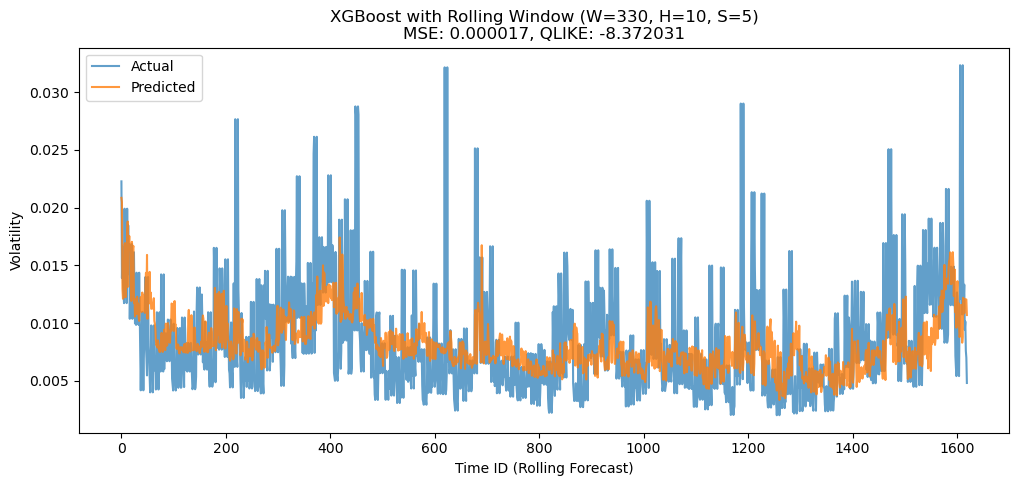

In [97]:
plt.figure(figsize=(12, 5))
plt.plot(actual, label="Actual", alpha=0.7)
plt.plot(pred, label="Predicted", alpha=0.8)
plt.title(f"XGBoost with Rolling Window (W={W}, H={H}, S={S})\nMSE: {mse:.6f}, QLIKE: {qlike:.6f}")
plt.xlabel("Time ID (Rolling Forecast)")
plt.ylabel("Volatility")
plt.legend()
plt.show()

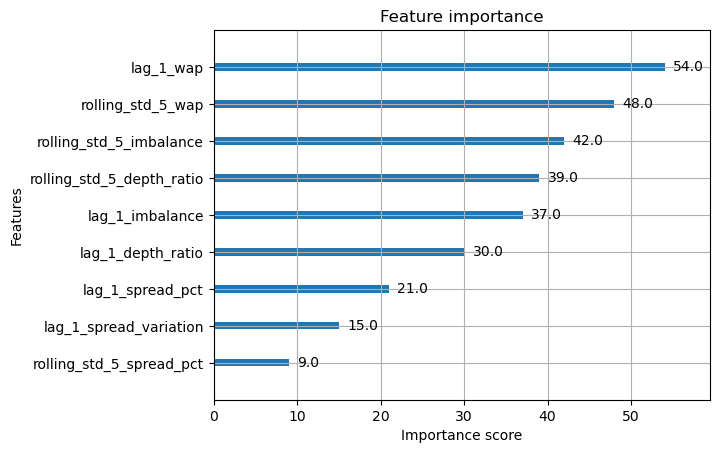

In [98]:
plot_importance(xgb_model3)
plt.show()

## Comparison

In [100]:
import pandas as pd

data = {
    'Model': ['Baseline', 'Rolling Windows', 'Hypertuned'],
    'MSE': [0.000019, 0.000019, 0.000017],
    'QLIKE': [-8.085424, -8.261772, -8.372031]
}

results_df = pd.DataFrame(data)
print(results_df.to_string(index=False))

          Model      MSE     QLIKE
       Baseline 0.000019 -8.085424
Rolling Windows 0.000019 -8.261772
     Hypertuned 0.000017 -8.372031
